In [64]:
%matplotlib inline
from numpy import *
from matplotlib.pyplot import *
from scipy.sparse.linalg import *

Consider the following one-dimensional PDE:
$$
-u_{xx}(x) = f(x)\quad\mathrm{ in }\ \Omega = (0, \pi)
$$
$$
u(x) = 0, \quad\mathrm{ on }\ \partial\Omega = \{0, \pi\}
$$

Given the following $4^{th}$ order finite difference approximation of the second order derivative:

$$u_{xx}(x_i) = \frac{-u_{i-2}+16u_{i-1}-30u_i+16u_{i+1}-u_{i+2}}{12h^2}$$

Implement a function that given the domain interval, the forcing function, the number of discretization points, the boundary conditions, returns the matrix $A$ and the the right hand side $b$.

In [65]:
def finDif(omega,f,n,bc):
    omg0=omega[0]
    omg1=omega[-1]
    h = ( omg1-omg0 )/(n-1)

    """ diagonal elements as per 4th order finite difference"""

    # constructing A
    c0 = 30*ones((n,))  
    c1 = -16*ones((n-1,))
    c2 = ones((n-2,))

    A = (diag(c0, 0) + diag(c1, -1) + diag(c1, +1) + diag(c2, -2) + diag(c2, +2))
    A /= 12.*h*h

    #print(A)
    #print(linalg.cond(A))

    # constructing b
    x = linspace(omg0, omg1, n)
    b = f(x)
    
    # boundary conditions 
    A[0,:] = A[:,0] = 0
    A[0,0] = A[-1,-1] = 1
    b[0] = bc[0]
    A[-1,:] = A[:,-1] = 0
    b[-1] = bc[-1]
    return A, b

Call the function using:

In [66]:
omega = [0,pi]
f = lambda x : sin(x)
n=100
bc = [0,0]
A, b = finDif(omega, f, n, bc)
#print(A)

Implement two functions that compute the LU and the Cholesky factorization of the system matrix $A$

In [67]:
"""LU factorization"""
def LU(A):
    A = A.copy()
    N = len(A)
    for k in range(N-1):
        if (abs(A[k,k]) < 1e-15):
            raise RuntimeError("Null pivot")

        A[k+1:N,k] /= A[k,k]
        for j in range(k+1,N):
            A[k+1:N,j] -= A[k+1:N,k]*A[k,j]

    L=tril(A)
    for i in range(N):
        L[i,i]=1.0
    U = triu(A)
    return L, U

L, U = LU(A)

In [68]:
"""Cholesky decomposition"""
def cholesky(A):
    A = A.copy()
    N = len(A)
    for k in range(N-1):
        A[k,k] = sqrt(A[k,k])
        A[k+1:N,k] = A[k+1:N,k]/A[k,k]
        
        for j in range(k+1,N):
            A[j:N,j] = A[j:N,j] - A[j:N,k]*A[j,k]
        
    A[-1,-1] = sqrt(A[-1,-1])
    L=tril(A)
    return L, L.transpose()

HT, H = cholesky(A)
  

Implement forward and backward substitution functions to exploit the developed factorization methods to solve the derived linear system of equations.

In [69]:
def L_solve(L,rhs):
    x = zeros_like(rhs)
    N = len(L)
    x[0] = rhs[0]/L[0,0]
    for i in range(1,N):
        x[i] = (rhs[i] - dot(L[i, 0:i], x[0:i]))/L[i,i]        
    return x

In [70]:
def U_solve(U,rhs):
    x = zeros_like(rhs)
    N = len(U)    
    x[-1] = rhs[-1]/L[-1,-1]
    for i in reversed(range(N-1)):
        x[i] = (rhs[i] - dot(U[i, i+1:N], x[i+1:N]))/U[i,i]
    return x

Solve the derived linear system using the implemented functions and plot the computed solution:

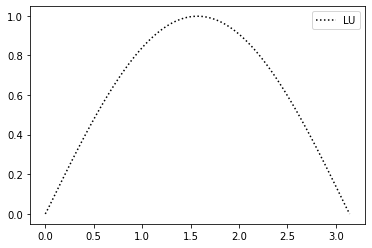

In [71]:
x = linspace(omega[0], omega[-1], n)
y_lu = L_solve(L,b)
u_lu = U_solve(U,y_lu)
_ =plot(x,u_lu,'black',linestyle='dotted', label='LU' )
_=legend()

Considering the new domain $\Omega = (0,1)$ and the forcing term $f(x) = x(1-x)$ with B.C. $u(x) = 0$, on $\partial \Omega = {0,1}$ produce a plot and a table where you show the decay of the error w.r.t. the number of grid points.
(The analytical solution for the above problems is $u_{an} = \frac{x^4}{12} - \frac{x^3}{6} + \frac{x}{12}$)

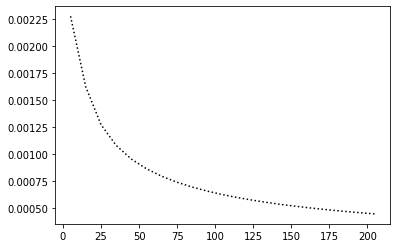

In [72]:
def errors(omega, f, bc, points):
    errors = []
    for i in range(len(points)):
        n = points[i]
        x = linspace(omega[0], omega[1], n)
        f_exact = x**4/12. - x**3/6. + x/12.
        An, bn = finDif(omega, f, n, bc)
        Ln, Un = LU(An)
        wn = L_solve(Ln, bn)
        un = U_solve(Un, wn)
        # get error
        err = linalg.norm(f_exact - un, 2)
        errors.append(err)
    
    return errors 
    
f = lambda x: x*(1-x)
points = list(range(5, 206, 10))
errors = errors([0,1], f, [0,0], points)
_ = plot(points, errors , 'black',linestyle='dotted') 

Exploit the derived LU factorizations to compute the condition number of the system's matrix $A$ using the original problem formulation.

In [73]:
# inverse power method 
def IPM(A, x0, mu, eps=1.0e-12, nmax=1000):
    M = A - mu*eye(len(A))
    L,U = LU(M)
    q = x0/linalg.norm(x0,2)
    err = eps + 1.0
    it = 0
    while (err > eps and it < nmax ):
        y = L_solve(L, q)
        x = U_solve(U, y)
        q = x/linalg.norm(x,2)
        z = dot(A,q)
        l = dot(q.T,z)
        err = linalg.norm(z-l*q,2)
        it += 1
    
    print("error_IPM =", err, "iterations_IPM =", it)
    print("lambda_IPM =", l)
    
    return l,q
    
# power method to compute
def PM(A, z0, tol=1e-12, nmax=1000):
    q = z0/linalg.norm(z0,2)
    it = 0
    err = tol + 1.
    while (it < nmax and err > tol):
        z = dot(A,q)
        l = dot(q.T,z)
        err = linalg.norm(z-l*q,2)
        q = z/linalg.norm(z,2)
        it += 1
    print("error_PM =", err, "iterations_PM =", it)
    print("lambda_PM =", l)
    return l,q

    #l,x = PM(A,z0)
    #l_np, x_np = numpy.linalg.eig(A)
    #print("numpy")
    #print(l_np)


# computes max and min eigenvalues
def condNumb(A):
    z0 = ones((len(A), ))
    lmax = PM(A, z0)[0]
    lmin = IPM(A, z0, 0.0)[0]
    return lmax/lmin

condNumb(A)


error_PM = 0.9199367691621815 iterations_PM = 1000
lambda_PM = 5289.569391713799
error_IPM = 0.4989280529999778 iterations_IPM = 1000
lambda_IPM = 0.5359935782624178


9868.717847071055

Implement a preconditioned Conjugant Gradient method to solve the original linear system of equations using an iterative method:

In [74]:
# conjugate gradient
def cg(A, b, P, nmax=len(A), eps=1e-10): 
    x = zeros_like(b)
    it = 0
    r = b - dot(A,x)
    tol = eps + 1
    N=len(A)
    rho_old = 1.
    p_old = zeros_like(b)
    while (it < nmax and tol > eps):
        it += 1
        z = linalg.solve(P,r)
        rho = dot(r,z)
        if (it > 1):
            beta = rho/rho_old
            p = z + beta*p_old
        else:
            p = z
        q = dot(A,p)
        alpha = rho/(dot(p,q))
        x += p*alpha
        r -= q*alpha
        
        p_old = p
        rho_old = rho
        
        tol = linalg.norm(r,2)
    return x

Consider the following time dependent variation of the PDE starting from the orginal problem formulation:
$$
u'(t)-u_{xx} = \alpha(t)f(x)
$$

for $t\in [0,T]$, with $\alpha(t) = \cos(t)$ and $T = 6\pi$

Use the same finite difference scheme to derive the semi-discrete formulation and solve it using a forward Euler's method.

Plot the time dependent solution solution at $x = \pi/2$, $x=1$, 
$x=\pi$


In [75]:
# forward Euler routine
def fe(u0,t0,tf,h,alpha,A,b):
    t = arange(t0,tf+1e-10, h)     
    sol = zeros((len(t), len(u0)))  
    sol[0] = u0
    for i in range(1,len(t)):
        u2 = -dot(A,sol[i-1])    
        af = alpha(t[i-1])*b       
        sol[i] = sol[i-1] + h*u2 + h*af
    
    return sol, t

error_PM = 0.9199367691621815 iterations_PM = 1000
lambda_PM = 5289.569391713799


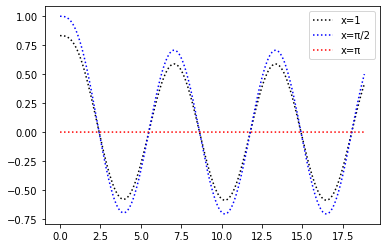

In [78]:
# plots
omega = [0, pi]
x2=(omega[-1] - omega[0])
val1 = round(n / x2 * pi/2.) -1
val2= round(n/x2) - 1
val3 = round(n/x2*pi) - 1
t0 = 0
tf = 6*pi
alpha = lambda y: cos(y)
max, vect = PM(A, ones_like(x)) 
h = 1/(max)

# u0 = sin(x)
u0 = sin(x)
sol, t = fe(u0,t0,tf, h,alpha, A,b)
_ = plot(t, sol[:,val2], 'black',linestyle='dotted',label='x=1')
_ = plot(t, sol[:,val1], 'blue',linestyle='dotted',label='x=π/2')
_ = plot(t, sol[:,val3], 'red',linestyle='dotted',label='x=π')
_ = legend()

Given the original $Au = b$ system, implement an algorithm to compute the eigenvalues and eigenvectors of the matrix $A$. Exploit the computed LU factorization

In [85]:
def eigenvalue_LU(A,eps,nmax):
    B = A.copy()
    val_old = np.diag(B)
    err = eps+1.0
    it = 0
    
    while it < nmax and err > eps:
        L,U = LU(B)
        B = U@L
        val_new = np.diag(B)  
        err = np.linalg.norm(val_new - val_old,2)
        it += 1
        val_old = val_new
        
    return val_new



Compute the inverse of the matrix A exploiting the derived LU factorization

In [86]:
def inverse(A):
    B=A.copy()
    I=eye(n)
    for i in range(n):
        B[:,i]=U_solve(U,L_solve(L,I[:,i]))
    return B

Consider the following Cauchy problem
$$
\begin{cases}
y'= -ty^2 \quad 0\le t \le 2\\
y(0) = 1
\end{cases}
$$
Implement a Backward Euler's method in a suitable function and solve the resulting non-linear equation using a Newton's method.

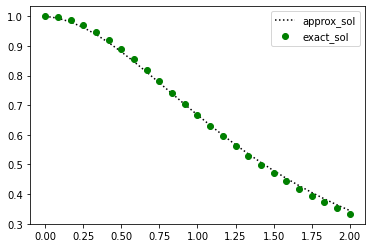

In [62]:
"""newton method"""
def newton(f,f_prime,x0,epsilon=1e-11,iter=1000):
    x = x0
    for n in range(0,iter):
        if abs(f(x)) < epsilon:
            return x
        if f_prime(x) == 0:
            return None
        x = x - f(x)/f_prime(x)
    return x


f=lambda t,y: -t*(y**2)
f_prime=lambda t,y: -t*2*y


"""backward euler"""
def b_euler(y0,g,g1,omega,n):
    tspace=linspace(omega[0],omega[1],n)
    h=(omega[1]-omega[0])/n
    f=lambda t,z,x: z-h*g(t,z)-x
    f1=lambda t,z,x: 1-h*g1(t,z)

    y=zeros(n)
    y[0]=y0

    for i in range(1,n):
        fn=lambda z: f(tspace[i],z,y[i-1])
        fn1=lambda z: f1(tspace[i],z,y[i-1])
        y[i]=newton(fn,fn1,y[i-1])
    return y
n=25
y=b_euler(1,f,f_prime,array([0,2]),n)
plot(linspace(0,2,n),y,'black',linestyle='dotted',label="approx_sol")
plot(linspace(0,2,n),2/(linspace(0,2,n)**2+2),'go',label="exact_sol")
_=legend()
